In [1]:
import sys
import os

# Check if running in Google Colab
if 'google.colab' in sys.modules:
    print("Found Google Colab environment.")
    from google.colab import drive
    drive.mount('/content/drive')
    # Set your path relative to the drive
    DATA_PATH = '/content/drive/My Drive/colab_cache/afmfold'
else:
    # We are running locally in VS Code
    # Set your path to where you stored the data locally
    DATA_PATH = './data/' # LOCAL path

print(f"Current data path is: {DATA_PATH}")

Found Google Colab environment.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current data path is: /content/drive/My Drive/colab_cache/afmfold


# Install Protenix and download the ccd_cache that we'll need later to convert the given protein to JSON.

In [18]:
cd /content/drive/My Drive/colab_cache/afmfold

/content/drive/My Drive/colab_cache/afmfold


In [19]:
!ls

build_main.sh		figures    paper	   results	src
build_supplementary.sh	LICENSE    pyproject.toml  results.zip	storage
downloads		notebooks  README.md	   scripts


In [4]:
!pip install -e .[e2cnn]

Obtaining file:///content/drive/My%20Drive/colab_cache/afmfold
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Cloning https://github.com/QUVA-Lab/e2cnn.git to /tmp/pip-install-39qp28s8/e2cnn_5e607e99730b4b408e2e50ead04528f6
  Running command git clone --filter=blob:none --quiet https://github.com/QUVA-Lab/e2cnn.git /tmp/pip-install-39qp28s8/e2cnn_5e607e99730b4b408e2e50ead04528f6
  Resolved https://github.com/QUVA-Lab/e2cnn.git to commit 022d6ca4a78ab666f3c149d1849e324ed1d40238
  Preparing metadata (setup.py) ... done
  Building editable for afmfold (pyproject.toml) ... done
  Created wheel for afmfold: filename=afmfold-0.1.0-0.editable-py3-none-any.whl size=4558 sha256=bd63f0278c6caf8df2551c523305bc5dc09ebd0538eec4d8e336ed14eb205de8
  Stored in directory: /tmp/pip-ephem-wheel-cache-i7z50gtq/wheels/ff/19/f4/c9fe3b40f29a40f7ce3

In [32]:
!pip install openmm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 98.5 MB/s eta 0:00:00


In [5]:
#%load_ext autoreload
#%autoreload 2

In [20]:
# Check that afmfold module is installed
!which afmfold

/usr/local/bin/afmfold


In [7]:
!nvcc --version
!python --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Python 3.12.12


In [8]:
import os
import sys
#sys.modules["deepspeed"] = None
import torch
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
import glob
from tqdm import tqdm
import itertools
import string

from afmfold.cnn import CNSteerableCNN
from afmfold.domain import compute_domain_distance, get_domain_pair_names, get_domain_pairs, FLHAC_DOMAINS
from afmfold.utils import compute_rmsd_single_frame, cat_dict
from afmfold.images import generate_images
from afmfold.inference import inference
from afmfold.visualization import plot_afm
from afmfold.visualization import (
    plot_afm, get_noise_robustness_axes, plot_explicit_heatmap, plot_hist,
    plot_bland_altman, get_color, plot_inter_domain_distance,
    )
from afmfold.evaluation import compute_time_correlation
from afmfold.rigid_body_fitting import RigidBodyFitting, run_rigid_body_fitting


Try to find the ccd cache data in the code directory for inference.


# Reproducibility Notebook

This notebook demonstrates the reproduction of the main results from the paper:

- (A) Conditional structure generation
- (B) Evaluation of estimation error using MD data
- (C) Noise robustness
- (D) Comparison with rigid-body fitting
- (E) Guidance scheduling
- (F) Overviewing training data

Some of the figures can be reproduced by installing the files from Zenodo.  
Please install them using the following command:

```bash
wget https://zenodo.org/records/17597490/files/afmfold.zip
unzip afmfold.zip
```


## (A) Conditional Structure Generation

We reproduce the conditional structure generation from pseudo-AFM images.

First, we generate pseudo-AFM images from example PDB structures (open/close).

In [9]:
AFMFOLD_DIR = "/content/drive/My Drive/colab_cache/afmfold"

In [10]:
# Peudo-AFM image generation settings
image_dict = {
    "distance": None,
    "resolution_nm": 0.3,
    "width": 35,
    "height": 35,
    "epochs": 1,
    "dataset_size": 1,
    "min_tip_radius": 1.0,
    "max_tip_radius": 2.0,
    "noise_nm": 0.0,
}

# Load example PDB structures (open/close)
close_traj = md.load(AFMFOLD_DIR+"/storage/1ake.pdb")
open_traj = md.load(AFMFOLD_DIR+"/storage/4ake.pdb")

# Generate pseudo-AFM images
close_images, _ = generate_images(traj=close_traj, **image_dict)
open_images, _ = generate_images(traj=open_traj, **image_dict)


Epoch 1/1: 100%|██████████| 1/1 [00:00<00:00, 247.16it/s]


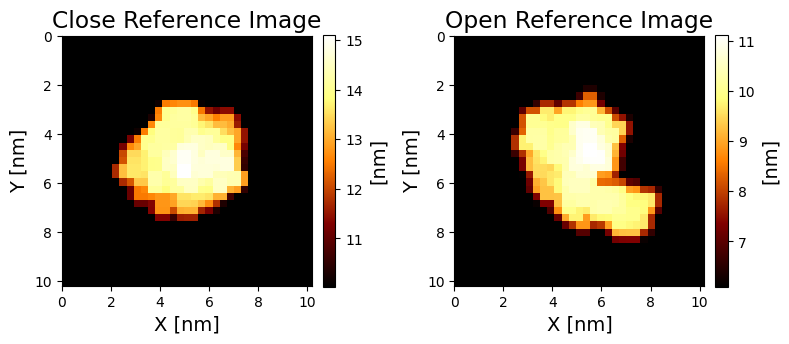

In [11]:
# Visualize the generated pseudo-AFM images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
_ = plot_afm(close_images, resolution_nm=0.3, subplots=(fig, axes[0]), title="Close Reference Image")
_ = plot_afm(open_images, resolution_nm=0.3, subplots=(fig, axes[1]), title="Open Reference Image")


Next, we load the pre-trained CNN.  
The model checkpoint is stored at `/data/kawai/TFEP/afmfold/storage/ak.pt`.

In [12]:
model, optim, ckpt = CNSteerableCNN.load_from_checkpoint(AFMFOLD_DIR+"/results/ak.pt")

/usr/local/lib/python3.12/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Before starting inference, please make sure that a JSON file `../storage/4ake.json` exists, which contains the location of the MSA.  
If it does not, either  
(i) run the following commands from `../`:
```bash
afmfold tojson --input ./storage/4ake.pdb --out_dir ./storage
afmfold msa --input ./storage/4ake.json --out_dir ./storage
```
or  
(ii) execute the following cell.

In [21]:
#!afmfold tojson --input "$AFMFOLD_DIR/storage/4ake.pdb" --out_dir "$AFMFOLD_DIR/storage"
!afmfold msa --input "$AFMFOLD_DIR/storage/4ake.json" --out_dir "$AFMFOLD_DIR/storage"

Try to find the ccd cache data in the code directory for inference.
2025-12-11 06:48:20,970 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/runner/batch_inference.py:441] INFO afmfold.runner.batch_inference: run msa with input=/content/drive/My Drive/colab_cache/afmfold/storage/4ake.json, out_dir=/content/drive/My Drive/colab_cache/afmfold/storage
2025-12-11 06:48:20,972 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/runner/msa_search.py:105] INFO afmfold.runner.msa_search: starting to update msa result for seq 0 in /content/drive/My Drive/colab_cache/afmfold/storage/4ake.json
2025-12-11 06:48:20,994 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/protenix/web_service/colab_request_utils.py:195] ERROR afmfold.protenix.web_service.colab_request_utils: Msa server is running.
COMPLETE: 100% 100/100 [00:00<00:00, 1058.49it/s]Files downloaded and extracted successfully.
COMPLETE: 100% 100/100 [00:00<00:00, 196.73it/s] 
2025-12-11 06:48:21,623 [/content/drive/My D

In [22]:
def _tojson(input_file, out_dir="./output", altloc="first", assembly_id=None):
    from afmfold.protenix.data.json_maker import cif_to_input_json
    from afmfold.protenix.data.utils import pdb_to_cif
    import tempfile
    import uuid
    os.makedirs(out_dir, exist_ok=True)
    stem, _ = os.path.splitext(os.path.basename(input_file))
    pdb_name = stem[:20]
    output_json = os.path.join(out_dir, f"{pdb_name}-{uuid.uuid4().hex}.json")
    if input_file.endswith(".pdb"):
        with tempfile.NamedTemporaryFile(suffix=".cif") as tmp:
            tmp_cif_file = tmp.name
            pdb_to_cif(input_file, tmp_cif_file)
            cif_to_input_json(
                tmp_cif_file,
                assembly_id=assembly_id,
                altloc=altloc,
                sample_name=pdb_name,
                output_json=output_json,
            )
    elif input_file.endswith(".cif"):
        cif_to_input_json(
            input_file,
            assembly_id=assembly_id,
            altloc=altloc,
            output_json=output_json,
        )
    else:
        raise RuntimeError(f"can not read a special ligand_file: {input_file}")
    return output_json

def _msa(input, out_dir):
    from afmfold.runner.msa_search import update_infer_json, msa_search
    from Bio import SeqIO
    if input.endswith(".json"):
        msa_input_json = update_infer_json(input, out_dir, use_msa_server=True)
        return msa_input_json
    elif input.endswith(".fasta"):
        records = list(SeqIO.parse(input, "fasta"))
        protein_seqs = []
        for seq in records:
            protein_seqs.append(str(seq.seq))
        protein_seqs = sorted(protein_seqs)
        msa_res_subdirs = msa_search(protein_seqs, out_dir)
        assert len(msa_res_subdirs) == len(msa_res_subdirs), "msa search failed"
        fasta_msa_res = dict(zip(protein_seqs, msa_res_subdirs))
        return fasta_msa_res
    else:
        raise RuntimeError(f"only support `json` or `fasta` format, but got : {input}")

# If you do not have a json file, you can create one from a PDB file as follows:
med_json = _tojson(AFMFOLD_DIR+"/storage/4ake.pdb", out_dir=AFMFOLD_DIR+"/storage", altloc="first", assembly_id=None)
output_json = _msa(med_json, AFMFOLD_DIR+"/storage")

# Check if MSA information is included in the generated JSON file
with open(output_json, "r") as f:
    input_data = json.load(f)
assert "msa" in input_data[0]["sequences"][0]["proteinChain"], f"MSA information is missing: {list(input_data[0]['sequences'][0]['proteinChain'].keys())}"
os.remove(med_json)

# Rename output_json {name}.json.
name = os.path.basename(output_json).split("-")[0]
json_path = os.path.join(AFMFOLD_DIR+"/storage", f"{name}.json")
os.rename(output_json, json_path)

2025-12-11 06:51:48,039 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/protenix/data/utils.py:426] INFO afmfold.protenix.data.utils: Saved cif in /tmp/tmp6s2qtdq2.cif
2025-12-11 06:52:01,311 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/runner/msa_search.py:105] INFO afmfold.runner.msa_search: starting to update msa result for seq 0 in /content/drive/My Drive/colab_cache/afmfold/storage/4ake-77d06d3b6bc74009a0020a7769e01602.json
2025-12-11 06:52:01,319 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/protenix/web_service/colab_request_utils.py:195] ERROR afmfold.protenix.web_service.colab_request_utils: Msa server is running.
2025-12-11 06:52:01,439 [/content/drive/My Drive/colab_cache/afmfold/src/afmfold/runner/msa_search.py:123] INFO afmfold.runner.msa_search: update msa result success and save to /content/drive/My Drive/colab_cache/afmfold/storage/4ake-77d06d3b6bc74009a0020a7769e01602-add-msa.json


Then, we use the prediction of this CNN as restraints for the AF3's generation process.  
The generation is iteratively performed until the MSE falls below the specified `mse_threshold`.  


In [24]:
# NOTE: To speed up the inference, use the previous inference results
# if you have run inference with a variety of restraints.

from afmfold.utils import get_restraints_prediction_pairs

inference_dirs = glob.glob(AFMFOLD_DIR+"/out/inference/4ake/seed_*")
domain_pairs = get_domain_pairs("4ake")
prev_restraints, prev_predictions = get_restraints_prediction_pairs(inference_dirs, domain_pairs)

ImportError: cannot import name 'get_restraints_prediction_pairs' from 'afmfold.utils' (/content/drive/My Drive/colab_cache/afmfold/src/afmfold/utils.py)

In [40]:
# NOTE: Set suppress = False to check out the progress.

close_cifs = inference(
    close_images,
    model,
    base_seed=0,
    device="cuda",
    json_file=AFMFOLD_DIR+"/storage/4ake.json",
    out_dir=AFMFOLD_DIR+"/out/inference",
    mse_threshold=10.0,  # in Å^2
    max_trial=5,
    traj=close_traj,
    #prev_restraints=prev_restraints,  # To speed up
    #prev_predictions=prev_predictions,  # To speed up
    suppress=True,
    )

open_cifs = inference(
    open_images,
    model,
    base_seed=0,
    device="cuda",
    json_file=AFMFOLD_DIR+"/storage/4ake.json",
    out_dir=AFMFOLD_DIR+"/out/inference",
    mse_threshold=10.0,  # in Å^2
    max_trial=5,
    traj=open_traj,
    #prev_restraints=prev_restraints,  # To speed up
    #prev_predictions=prev_predictions,  # To speed up
    suppress=True,
    )

  0%|          | 0/1 [00:32<?, ?it/s]


NameError: name 'openmm_unit' is not defined

In [38]:
import openmm

print('openmm.unit' in sys.modules)

repr(openmm.unit.Quantity)


True


"<class 'openmm.unit.quantity.Quantity'>"

In [ ]:
print([os.path.relpath(p) for p in close_cifs])
print([os.path.relpath(p) for p in open_cifs])

Since the rigid-body fitting code supports batch processing, we combine the two results here.

In [ ]:
# Concatenate the predicted structures
close_pred_traj = md.load(close_cifs[-1])
open_pred_traj = md.load(open_cifs[-1])
cat_pred_traj = md.join([close_pred_traj, open_pred_traj])
cat_ref_images = np.concatenate([close_images, open_images], axis=0)

In [ ]:
output_dirs=[
    os.path.dirname(os.path.dirname(close_cifs[-1])),
    os.path.dirname(os.path.dirname(open_cifs[-1])),
]

summary = run_rigid_body_fitting(
    output_dirs=output_dirs,
    ref_pdb="../storage/4ake.pdb",
    steps=5000,
    resolution_nm=0.3,
    prove_radius_range=(1.0, 2.0),
    prove_radius=None,
    min_z=0.0,
    use_ref_structure=False,
    save_all=False,
)

Then, let's visualize the results.

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 9))
_ = plot_afm(summary["ref_images"], resolution_nm=0.3, subplots=(fig, axes[0,:]), title=["Close Reference Image", "Open Reference Image"])
_ = plot_afm(summary["top_pred_images"], resolution_nm=0.3, subplots=(fig, axes[1,:]), title=["Close Predicted Image", "Open Predicted Image"])

## (B) Evaluation with MD Data

We evaluate the statistic prediction accuracy using MD trajectories.  

First, we load MD trajectory data. This trajectory has 64 representive frames from 450 ns MD trajectory.

In [ ]:
# Load reference trajectory
ref_traj = md.load("../results/ak.dcd", top="../results/ak.pdb")

# Compute inter-domain distances.
domain_pairs = get_domain_pairs("4ake")
ref_domain_distance = np.zeros((ref_traj.n_frames, len(domain_pairs)))

for i, (dom1, dom2) in enumerate(domain_pairs):
    ref_domain_distance[:, i] = compute_domain_distance(ref_traj, dom1, dom2).ravel()


Next, let's convert MD frames into pseudo-AFM images.  

In [ ]:
image_dict = {
    "traj": ref_traj,
    "distance": ref_domain_distance,
    "resolution_nm": 0.3,
    "width": 35,
    "height": 35,
    "epochs": 2,
    "dataset_size": 100,
    "min_tip_radius": 1.0,
    "max_tip_radius": 2.0,
    "noise_nm": 0.0,
}

# Generate pseudo-AFM images for the reference trajectory
images, labels = generate_images(**image_dict)

# Find the corresponding frames in the reference trajectory
indices = np.array([np.argmax(np.all(image_dict["distance"] == labels[i][None,:], axis=1)) for i in range(len(labels))])
frames = image_dict["traj"].atom_slice(image_dict["traj"].topology.select("element != H"))[indices]


In [ ]:
images.shape

In [ ]:
# Visualize one of the generated images
fig, ax = plt.subplots(figsize=(5.0, 4.0))
_ = plot_afm(images[0], resolution_nm=0.3, subplots=(fig, ax), title="Reference Image from MD Trajectory")
plt.tight_layout()
plt.show()

Then, we load CNN parameters and start the AF3's generation conditioned on these images.  

In [ ]:
model, optim, ckpt = CNSteerableCNN.load_from_checkpoint("../results/ak.pt")

In [ ]:
device = torch.device("cuda")
model = model.to(device)

If you run the following cell, the structure estimation will start. Because it will take a long time,
we reccomend to use the script.

First, save `images`, `labels` and `frames` wherever you like.
```python
np.save(os.path.join("your/inference/directory", f"ak_image.npy"), images)
np.save(os.path.join("your/inference/directory", f"ak_label.npy"), labels)
frames.save_dcd(os.path.join("your/inference/directory", f"ak_traj.dcd"))
frames[0].save_pdb(os.path.join("your/inference/directory", f"ak_traj.pdb"))
```

After that, run the following command from `../`.

```bash
nohup python scripts/inference.py \
    --name 4ake \
    --image-path your/image/directory/ak_image.npy \
    --label-path your/image/directory/ak_label.npy \
    --dcd-path your/image/directory/ak_traj.dcd \
    --pdb-path your/image/directory/ak_traj.pdb \
    --ckpt ./results/ak.pt \
    --json-path ./storage/4ake.json \
    --out-dir ./out/inference \
    --device cuda \
    > inference.log 2>&1 &
```

In [ ]:
json_file = "../storage/4ake.json"  # if you do not have a json file, create one from a PDB file as shown above.
out_dir = "../out/inference"

cif_list = inference(images, model, json_file, out_dir, base_seed=0, device="cuda", max_trial=5, labels=labels, traj=frames)

After finishing the inference, we evaluate the estimation error statistics.

Again, runnning the following cell will take a long time, to we recommend to use the script.

If all inference result is stored in `../out/inference/4ake/seed_*`, run the following command in `../`.

```bash
nohup python scripts/rigid_body_fitting.py \
    --output_dir out/inference/4ake/seed_* \
    --ref-pdb storage/4ake.pdb \
    --resolution-nm 0.3 \
    --name fitting \
    --prove-radius-mean 1.0 \
    --prove-radius-range 1.0 \
    --prove-radius-step 1.0 \
    --steps 50000 \
    --skip-finished \
    > fitting.log 2>&1 &
```

In [ ]:
output_dirs = glob.glob("../out/inference/4ake/seed_*")
summary = run_rigid_body_fitting(output_dirs, ref_pdb="../storage/4ake.pdb", steps=50000, stop_at=None, batchsize=20)

In [ ]:
# NOTE: If you want to see the results of the paper, please load the following results.
summary = np.load("../results/ak_summary.npz")
#summary = np.load("../results/ak_summary_noisy.npz")  # Inference results with 0.3 nm noise
summary = dict(summary)

In [ ]:
def plot_inference_results(
    summary,
    subplots=None,
    axsize=4.0,
    fontsize=14.0,
    bins=30,
    fig_padding=2.0,
    hist_padding=0.10,
    scatter_padding=0.05,
    scale_bins=5,
    compute_root=True,
):
    # --- helpers (no for-loops) ---
    def _metric_label(key: str) -> str:
        # ignore "valid" / "valid_pred", keep last token and uppercase
        label = key.split("_")[-1].upper()
        if label == "ERROR":
            if compute_root:
                label = "Root Squared Error of Inter-domain Distance [nm]"
            else:
                label = "Inter-domain Squared Error [nm$^2$]"
        elif label == "RMSD":
            label = "RMSD [nm]"
        elif label == "CC":
            label = "c.c."
        return label

    def _nice_ticks(lo, hi, bins_n, name=None):
        center = (lo + hi) / 2
        width = (1 + hist_padding) * (hi - lo)
        lo_p, hi_p = center - width / 2, center + width / 2
        step = width / bins_n
        if step <= 0.01:
            decimal = 3
        elif step <= 0.5:
            decimal = 2
        else:
            decimal = 1

        # round outward to include the padded range
        scale = 10 ** decimal
        lo_r = np.floor(lo_p * scale) / scale
        hi_r = np.ceil(hi_p * scale) / scale

        step_r = np.round(step, decimal)
        # ensure positive nonzero step
        step_r = step_r if step_r > 0 else (0.1 if decimal == 1 else 0.01)

        name = name.split("_")[-1].upper()
        if name == "CC":
            #hi_r = min(hi_r + step_r, 1.0)
            hi_r = 1.0
        elif name == "ERROR":
            lo_r = max(lo_r, 0.0)
            lo_r -= 0.5 * step_r
        elif name == "RMSD":
            lo_r = max(lo_r, 0.0)
            hi_r += step_r

        ticks = np.arange(lo_r, hi_r, step_r)
        ticks = np.round(ticks, decimal)

        return ticks, (lo_r, hi_r)

    def _hist(ax, data, color, name=None):
        lo, hi = np.nanmin(data), np.nanmax(data)
        ticks, (lo_r, hi_r) = _nice_ticks(lo, hi, scale_bins, name=name)
        ax.hist(data, bins=bins, range=(lo_r, hi_r), density=True, color=color, edgecolor="white")
        mu = float(np.nanmean(data))
        ax.axvline(mu, linestyle="--", color="k", linewidth=1.2)
        ax.set_xlim(lo_r, hi_r)
        ax.set_xticks(ticks)
        ax.set_yticks(ax.get_yticks())  # keep default nice y ticks
        ax.tick_params(labelsize=fontsize * 0.85)

    def _scatter(ax, x, y, dot_color, names=[None,None], xmin=None, xmax=None, ymin=None, ymax=None):
        xlo = np.nanmin(x)
        xhi = np.nanmax(x)
        ylo = np.nanmin(y)
        yhi = np.nanmax(y)
        xticks, (xlo_r, xhi_r) = _nice_ticks(xlo, xhi, scale_bins, name=names[0])
        yticks, (ylo_r, yhi_r) = _nice_ticks(ylo, yhi, scale_bins, name=names[1])
        ax.scatter(x, y, s=16, alpha=0.75, color=dot_color, edgecolors="none")
        # linear regression line (thin light gray)
        coeffs = np.polyfit(np.asarray(x), np.asarray(y), 1)
        xs = np.array([xlo_r, xhi_r])
        ys = coeffs[0] * xs + coeffs[1]
        ax.plot(xs, ys, linewidth=1.5, color="#cfcfcf", ls="--")
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_xlim(xlo_r, xhi_r)
        ax.set_ylim(ylo_r, yhi_r)
        ax.tick_params(labelsize=fontsize * 0.85)

    print("MSE: ", np.mean(summary['squared_error']))
    print(f"RMSE: {np.mean(np.sqrt(summary['squared_error']))}")
    print(f"RRMSD: {np.mean(summary['rmsd'])}")
    print(f"MCC: {np.mean(summary['cc'])}")

    # --- layout ---
    if subplots is None:
        fig, axes = plt.subplots(2, 3, figsize=(3 * axsize + fig_padding, 2 * axsize), constrained_layout=True)
    else:
        fig, axes = subplots

    # --- histograms (colors fixed as requested) ---
    if compute_root:
        _hist(axes[0, 0], np.sqrt(summary["squared_error"]), color="salmon", name="squared_error")
    else:
        _hist(axes[0, 0], summary["squared_error"], color="salmon", name="squared_error")
    _hist(axes[0, 1], summary["rmsd"], color="skyblue", name="rmsd")
    _hist(axes[0, 2], summary["cc"], color="moccasin", name="cc")

    # --- scatter plots (choose pleasant, distinct colors not overlapping with histogram palette) ---
    if compute_root:
        _scatter(axes[1, 0], np.sqrt(summary["squared_error"]), summary["rmsd"], dot_color="mediumseagreen", names=["squared_error", "rmsd"])
    else:
        _scatter(axes[1, 0], summary["squared_error"], summary["rmsd"], dot_color="mediumseagreen", names=["squared_error", "rmsd"])
    _scatter(axes[1, 1], summary["squared_error"], summary["cc"], dot_color="orchid", names=["squared_error", "cc"])
    _scatter(axes[1, 2], summary["cc"], summary["rmsd"], dot_color="steelblue", names=["cc", "rmsd"])

    # --- labels (no titles) ---
    # row 1: histograms (x-labels only)
    axes[0, 0].set_xlabel(_metric_label("squared_error"), fontsize=fontsize)
    if compute_root:
        axes[0, 0].set_ylabel("Density [nm$^{-1}$]", fontsize=fontsize)
    else:
        axes[0, 0].set_ylabel("Density [nm$^{-2}$]", fontsize=fontsize)
    axes[0, 1].set_xlabel(_metric_label("rmsd"), fontsize=fontsize)
    axes[0, 1].set_ylabel("Density [nm$^{-1}$]", fontsize=fontsize)
    axes[0, 2].set_xlabel(_metric_label("cc"), fontsize=fontsize)
    axes[0, 2].set_ylabel("Density", fontsize=fontsize)
    # row 2: scatters (x and y)
    axes[1, 0].set_xlabel(_metric_label("squared_error"), fontsize=fontsize)
    axes[1, 0].set_ylabel(_metric_label("rmsd"), fontsize=fontsize)
    axes[1, 1].set_xlabel(_metric_label("squared_error"), fontsize=fontsize)
    axes[1, 1].set_ylabel(_metric_label("cc"), fontsize=fontsize)
    axes[1, 2].set_xlabel(_metric_label("cc"), fontsize=fontsize)
    axes[1, 2].set_ylabel(_metric_label("rmsd"), fontsize=fontsize)
    fig.tight_layout()

    return fig, axes


In [ ]:
fig, axes = plot_inference_results(summary, fontsize=13, compute_root=True)

## (C) Noise robustness

Here, we demonstrate the results of noise robustness. The results are displayed by downloading the actual outputs from the execution. For strict reproducibility, please refer to the `README.md`.

The filename of the distributed result, for example `0.1-0.2.npz`, indicates that:

- A CNN was trained on training data with Gaussian noise with a standard deviation = **0.1 nm**, and
- The conformations was estimated from reference images with Gaussian noise with a standard deviation = **0.2 nm**.


In [ ]:
def analyze_noise_robustness(
    npz_files, ref_pdb,
    steps=50000, resolution_nm=0.3, device="cuda", is_tqdm=False, strict=False,
    prove_radius=2.0, min_z=0.0, translation_range=(-5.0, 5.0), rot_batch=1,
    ):
    ref_traj = md.load(ref_pdb)
    npz_basedir = os.path.dirname(npz_files[0])
    training_noise_arr = np.array(sorted(list(set([float(os.path.basename(path).split(".npz")[0].split("-")[0]) for path in npz_files]))))
    reference_noise_arr = np.array(sorted(list(set([float(os.path.basename(path).split(".npz")[0].split("-")[1]) for path in npz_files]))))
    cc_table = np.zeros((len(training_noise_arr), len(reference_noise_arr)))
    rmsd_table = np.zeros((len(training_noise_arr), len(reference_noise_arr)))
    image_dict = {}
    for idx in tqdm(range(len(training_noise_arr) * len(reference_noise_arr)), disable=not is_tqdm):
        i = idx // len(reference_noise_arr)
        j = idx % len(reference_noise_arr)
        training_noise = training_noise_arr[i]
        reference_noise = reference_noise_arr[j]
        npz_path = os.path.join(npz_basedir, f"{training_noise.item()}-{reference_noise.item()}.npz")
        data = dict(np.load(npz_path))
        assert data["training_noise"] == training_noise
        assert data["reference_noise"] == reference_noise

        ref_images = data["images"]

        if reference_noise.item() not in image_dict:
            image_idx = np.random.choice(len(ref_images), (1,)).item()
            image_dict[reference_noise.item()] = ref_images[image_idx]

        true_coords = data["ref_coords"]
        pred_coords = data["pred_coords"]
        true_traj = md.Trajectory(true_coords, topology=ref_traj.topology)
        pred_traj = md.Trajectory(pred_coords, topology=ref_traj.topology)

        if "rmsds" in data and not strict:
            rmsds = data["rmsds"]
        else:
            rmsds = np.zeros((len(true_traj),))
            for iframe in range(len(true_traj)):
                rmsd = compute_rmsd_single_frame(true_traj[iframe], pred_traj[iframe])
                rmsds[iframe] = rmsd.item()

        rmsd_table[i, j] = np.mean(rmsds)

        if "ccs" in data and not strict:
            max_ccs = data["ccs"]
        else:
            fitting = RigidBodyFitting(
                ref_images, pred_traj, steps,
                resolution_nm=resolution_nm, prove_radius=prove_radius, min_z=min_z,
                ref_pdb=ref_pdb, rot_batch=rot_batch, translation_range=translation_range, device=device,
                )
            summery = fitting.sample(desc=f"Epoch {idx+1}/{len(training_noise_arr) * len(reference_noise_arr)}")
            max_ccs = np.max(summery["cc"], axis=1)

        cc_table[i, j] = np.mean(max_ccs).item()

    results = {
        "image_dict": image_dict,
        "training_noise_arr": training_noise_arr,
        "reference_noise_arr": reference_noise_arr,
        "rmsd_table": rmsd_table,
        "cc_table": cc_table,
    }
    return results

def plot_noise_robustness(results, resolution_nm=0.3, fontsize=14.0, add_label=True):
    fig, axes = get_noise_robustness_axes()

    if add_label:
        for i, ax in enumerate([axes[0], axes[4], axes[5]]):
            label = f"{string.ascii_lowercase[i]}"
            if i == 0:
                xt = -0.3
                yt = 1.5
            else:
                xt = -0.15
                yt = 1.2
            ax.text(
                xt, yt, label,               # ← 図の外側左上に配置
                transform=ax.transAxes,
                fontsize=25, fontweight="bold",
                va="bottom", ha="left"
            )

    for i in range(4):
        noise_nm = results["training_noise_arr"][i].item()
        img = results["image_dict"][noise_nm]
        title = f"{noise_nm:.1f} [nm]"
        plot_afm(img, resolution_nm=resolution_nm, subplots=(fig, axes[i]), title=title, fontsize=fontsize)

    plot_explicit_heatmap(
        results["training_noise_arr"],
        results["reference_noise_arr"],
        results["rmsd_table"],
        xlabel='Noise SD in training images [nm]',
        ylabel='Noise SD in "experimental" images [nm]',
        zlabel='Mean RMSD [nm]',
        subplots=(fig, axes[4]),
        fontsize=fontsize,
        )

    plot_explicit_heatmap(
        results["training_noise_arr"],
        results["reference_noise_arr"],
        results["cc_table"],
        xlabel='Noise SD in training images [nm]',
        ylabel='Noise SD in "experimental" images [nm]',
        zlabel="c.c.",
        subplots=(fig, axes[5]),
        fontsize=fontsize,
        )

    plt.tight_layout()

    return fig, axes


In [ ]:
npz_files = glob.glob("../results/noise_robustness/*.npz")
results = analyze_noise_robustness(npz_files, ref_pdb="../storage/4ake.pdb", steps=5000, device="cuda", strict=False)

In [ ]:
fig, axes = plot_noise_robustness(results, add_label=False, fontsize=18.0)

## (D) Comparison with Rigid-Body Fitting

We compare our method against rigid-body fitting as a baseline.  

First, we generate images from MD trajectories. Here, we assume them as the real AFM data.

In [ ]:
ref_traj = md.load(
    "../results/flhac_conformations/msa_subsampling/msa_subsampling_3a5i.dcd",
    top="../results/flhac_conformations/msa_subsampling/msa_subsampling_3a5i.pdb",
    )
ref_traj

In generating pseudo-AFM images, we use `skimage.exposure.match_histograms` to match histograms so that generated images are close to real AFM images.
Note that, in the paper, we actually performed histogram matching during the generation of training data.  


In [ ]:
real_image_histogram = np.load("../results/real_afm_histogram.npy")

In [ ]:
# Peudo-AFM image generation settings
image_dict = {
    "distance": None,
    "resolution_nm": 0.98,
    "width": 35,
    "height": 35,
    "epochs": 1,
    "dataset_size": len(ref_traj),
    "min_tip_radius": 2.0,
    "max_tip_radius": 5.0,
    "noise_nm": 1.0,
    "ref_images": real_image_histogram,
    "match_histgram": True,
}

# Generate pseudo-AFM images
ref_images, _ = generate_images(traj=ref_traj, **image_dict)

In [ ]:
fig, ax = plt.subplots(figsize=(5.0, 4.0))
_ = ax.hist(real_image_histogram, bins=100, histtype='step', density=True, color="salmon", label="Real data")
_ = ax.hist(ref_images.ravel(), bins=100, histtype='step', density=True, color="lightblue", label="Pseudo-AFM data")
ax.legend(fontsize=12)
plt.show()

In [ ]:
target_afm_images = ref_images[[0, 1, 2]]
_ = plot_afm(target_afm_images, resolution_nm=0.98)

Next, we load the pre-trained CNN model.

In [ ]:
model, optim, ckpt = CNSteerableCNN.load_from_checkpoint("../results/flhac.pt")

Also, get the json file with MSA path.

In [ ]:
def _tojson(input_file, out_dir="./output", altloc="first", assembly_id=None):
    from afmfold.protenix.data.json_maker import cif_to_input_json
    from afmfold.protenix.data.utils import pdb_to_cif
    import tempfile
    import uuid
    os.makedirs(out_dir, exist_ok=True)
    stem, _ = os.path.splitext(os.path.basename(input_file))
    pdb_name = stem[:20]
    output_json = os.path.join(out_dir, f"{pdb_name}-{uuid.uuid4().hex}.json")
    if input_file.endswith(".pdb"):
        with tempfile.NamedTemporaryFile(suffix=".cif") as tmp:
            tmp_cif_file = tmp.name
            pdb_to_cif(input_file, tmp_cif_file)
            cif_to_input_json(
                tmp_cif_file,
                assembly_id=assembly_id,
                altloc=altloc,
                sample_name=pdb_name,
                output_json=output_json,
            )
    elif input_file.endswith(".cif"):
        cif_to_input_json(
            input_file,
            assembly_id=assembly_id,
            altloc=altloc,
            output_json=output_json,
        )
    else:
        raise RuntimeError(f"can not read a special ligand_file: {input_file}")
    return output_json

def _msa(input, out_dir):
    from afmfold.runner.msa_search import update_infer_json, msa_search
    from Bio import SeqIO
    if input.endswith(".json"):
        msa_input_json = update_infer_json(input, out_dir, use_msa_server=True)
        return msa_input_json
    elif input.endswith(".fasta"):
        records = list(SeqIO.parse(input, "fasta"))
        protein_seqs = []
        for seq in records:
            protein_seqs.append(str(seq.seq))
        protein_seqs = sorted(protein_seqs)
        msa_res_subdirs = msa_search(protein_seqs, out_dir)
        assert len(msa_res_subdirs) == len(msa_res_subdirs), "msa search failed"
        fasta_msa_res = dict(zip(protein_seqs, msa_res_subdirs))
        return fasta_msa_res
    else:
        raise RuntimeError(f"only support `json` or `fasta` format, but got : {input}")

# If you do not have a json file, you can create one from a PDB file as follows:
med_json = _tojson("../storage/3a5i.pdb", out_dir="../storage", altloc="first", assembly_id=None)
output_json = _msa(med_json, "../storage")

# Check if MSA information is included in the generated JSON file
with open(output_json, "r") as f:
    input_data = json.load(f)
assert "msa" in input_data[0]["sequences"][0]["proteinChain"], f"MSA information is missing: {list(input_data[0]['sequences'][0]['proteinChain'].keys())}"
os.remove(med_json)

# Rename output_json {name}.json.
name = os.path.basename(output_json).split("-")[0]
json_path = os.path.join("../storage", f"{name}.json")
os.rename(output_json, json_path)


Finally, we start inference from the afm images.

In [ ]:
# To speed up the inference, use the previous inference results
# if you have run inference with a variety of restraints.

from afmfold.utils import get_restraints_prediction_pairs

inference_dirs = glob.glob("../out/inference/3a5i/seed_*")
domain_pairs = get_domain_pairs("3a5i")
prev_restraints, prev_predictions = get_restraints_prediction_pairs(inference_dirs, domain_pairs)

In [ ]:
json_file = "../storage/3a5i.json"
out_dir = "../out/inference"

cif_list = inference(
    target_afm_images,
    model,
    json_file,
    out_dir,
    base_seed=0,
    in_nm=True,  # Because the CNN's output is in nm
    #prev_restraints=prev_restraints,  # To speed up
    #prev_predictions=prev_predictions,  # To speed up
    device="cuda",
    max_trial=3,
    )

In [ ]:
output_dirs = [os.path.relpath(os.path.dirname(os.path.dirname(p))) for p in cif_list]
output_dirs

To perform rigid-body fitting between the predicted structure and the crystal structure,  
set the `use_ref_structure` flag to `True` and then run the `run_rigid_body_fitting` function.

In [ ]:
total_summary = run_rigid_body_fitting(
    output_dirs,
    ref_pdb="../storage/3a5i.pdb",
    resolution_nm=0.98,
    prove_radius=None,
    prove_radius_range=(2.0, 6.0),
    min_z=0.0,
    steps=5000,
    stop_at=None,
    batchsize=20,
    use_ref_structure=True,
    save_all=False,
    device="cuda",
    )

Finally, let’s plot the results of the rigid-body fitting.

In [ ]:
print(list(total_summary.keys()))

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
fontsize = 12
decimals = 4
r = 0.5
ref_traj = md.load("../storage/3a5i.pdb")

reference_label = "Reference"
pdb_label = "Crystal"
afmfold_label = "AFM-Fold"

for i in range(len(total_summary["ref_images"])):
    _ = plot_afm(
        total_summary["ref_images"][i], subplots=(fig, axes[i,0]), title=reference_label, fontsize=fontsize,
        )

    pdb_traj = md.Trajectory(total_summary["top_pred_coords_pdb"][i][None,:,:], topology=ref_traj.topology)
    _ = plot_afm(
        total_summary["top_pred_images_pdb"][i], subplots=(fig, axes[i,1]), title=pdb_label, fontsize=fontsize,
        traj=pdb_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(total_summary['top_cc_pdb'][i], decimals=decimals).item()}",
        )

    pred_traj = md.Trajectory(total_summary["top_pred_coords"][i][None,:,:], topology=ref_traj.topology)
    _ = plot_afm(
        total_summary["top_pred_images"][i], subplots=(fig, axes[i,2]), title=afmfold_label, fontsize=fontsize,
        traj=pred_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(total_summary['top_cc'][i], decimals=decimals).item()}",
        )

fig.tight_layout()
fig.show()

In [ ]:
npz_files = glob.glob("../results/real_afm/frame_*.npz")

all_frame_data = {}
pbar = tqdm(npz_files, total=len(npz_files))
for npz_file in pbar:
    frame_data = dict(np.load(npz_file))
    all_frame_data = cat_dict(all_frame_data, frame_data)

In [ ]:
domain_names = get_domain_pair_names("3a5i")

fig, ax = plot_bland_altman(
    all_frame_data["fitting_cc_pdb"], all_frame_data["fitting_cc"],
    color=0.1*all_frame_data["pred_domain_distance"][:,1],
    color_label=" - ".join(domain_names[1]).strip() + " distance [nm]",
    data1_label=r"c.c.$_{\mathrm{Crystal}}$",
    data2_label=r"c.c.$_{\mathrm{AFMFold}}$",
    fontsize=15,
    tick_fontsize=12,
    bbox_to_anchor=(0.5, -0.2)
    )
fig.tight_layout()
fig.show()

In [ ]:
num_frames = 100

alphaflow_md_traj = md.load(
    "../results/flhac_conformations/alphaflow/aflow_md_3a5i_1.dcd",
    top="../results/flhac_conformations/alphaflow/aflow_md_3a5i_1.pdb",
)[:num_frames]

alphaflow_pdb_traj = md.load(
    "../results/flhac_conformations/alphaflow/aflow_pdb_3a5i_1.dcd",
    top="../results/flhac_conformations/alphaflow/aflow_pdb_3a5i_1.pdb",
)[:num_frames]

bioemu_traj = md.load(
    "../results/flhac_conformations/bioemu/bioemu_3a5i_1.dcd",
    top="../results/flhac_conformations/bioemu/bioemu_3a5i_1.pdb",
)[:num_frames]

msa_subsampling_traj = md.load(
    "../results/flhac_conformations/msa_subsampling/msa_subsampling_3a5i.dcd",
    top="../results/flhac_conformations/msa_subsampling/msa_subsampling_3a5i.pdb",
)[:num_frames]

In [ ]:
domain_pairs = get_domain_pairs("3a5i")
domain_names = get_domain_pair_names("3a5i")

alphaflow_md_d24 = compute_domain_distance(alphaflow_md_traj, *domain_pairs[1])
alphaflow_pdb_d24 = compute_domain_distance(alphaflow_pdb_traj, *domain_pairs[1])
bioemu_d24 = compute_domain_distance(bioemu_traj, *domain_pairs[1])
msa_subsampling_d24 = compute_domain_distance(msa_subsampling_traj, *domain_pairs[1])

In [ ]:
vmin, vmax = 2.20, 6.50
fontsize = 15.0
tick_fontsize = 13.0
density = True

fig, ax = plt.subplots(figsize=(6, 6))
_ = plot_hist(0.1 * all_frame_data["pred_domain_distance"][:,1], color="salmon", subplots=(fig, ax), vmin=vmin, vmax=vmax, density=density, label="AFM-Fold", fontsize=fontsize)
_ = plot_hist(alphaflow_md_d24, color="slateblue", subplots=(fig, ax), stepfilled=True, ls=":", lw=1.5, vmin=vmin, vmax=vmax, density=density, label="AlphaFlow_MD", fontsize=fontsize)
_ = plot_hist(alphaflow_pdb_d24, color="forestgreen", subplots=(fig, ax), stepfilled=True, ls="--", lw=1.5, vmin=vmin, vmax=vmax, density=density, label="AlphaFlow_PDB", fontsize=fontsize)
_ = plot_hist(bioemu_d24, color="navy", subplots=(fig, ax), stepfilled=True, ls="-", lw=1.5, vmin=vmin, vmax=vmax, density=density, label="BioEmu", fontsize=fontsize)
_ = plot_hist(msa_subsampling_d24, color="darkred", subplots=(fig, ax), stepfilled=True, ls="-.", lw=1.5, vmin=vmin, vmax=vmax, density=density, label="MSA subsampling", fontsize=fontsize)
ax.set_xlabel(" - ".join(domain_names[1]).strip() + " distance [nm]", fontdict={"fontsize": fontsize})
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.set_ylabel("Density [nm$^{-1}$]", fontdict={"fontsize": fontsize})
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=fontsize)
fig.tight_layout()
fig.show()

In [ ]:
# Load coordinates
ref_traj = md.load("../storage/3a5i.pdb")
traj = md.Trajectory(
    all_frame_data["output_coords"],
    topology=ref_traj.topology
)

# Compute all inter-domain distance
all_domain_pairs = list(itertools.combinations([(k, v) for k, v in FLHAC_DOMAINS.items()], 2))
all_domain_distance = np.zeros((len(traj), len(all_domain_pairs)))
all_domain_pair_names = []
for i, (d1, d2) in enumerate(all_domain_pairs):
    pair_name = f"{d1[0]} - {d2[0]}"
    all_domain_distance[:,i] = compute_domain_distance(traj, d1[1], d2[1]).ravel()
    all_domain_pair_names.append(pair_name)

In [ ]:
time_correlation_list = []
randperm_time_correlation_list = []

lags = np.arange(1, 20)

for lag in lags:
    perm = np.random.permutation(len(all_domain_distance))

    time_corr = compute_time_correlation(all_domain_distance, lag=lag)
    time_correlation_list.append(time_corr[None,...])

    randperm_time_corr = compute_time_correlation(all_domain_distance[perm,:], lag=lag)
    randperm_time_correlation_list.append(randperm_time_corr[None,...])

time_correlations = np.concatenate(time_correlation_list, axis=0)
randperm_time_correlations = np.concatenate(randperm_time_correlation_list, axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
fontsize = 16
tick_fontsize = 12

markers = ['o', '^', 's', 'x', '+', '.', '*']
for i in range(len(all_domain_pairs)):
    ax.plot(lags, time_correlations[:,i], label=all_domain_pair_names[i], color=get_color(i, len(all_domain_pairs)), marker=markers[i%len(markers)])
    ax.plot(lags, randperm_time_correlations[:,i], linestyle=":", color=get_color(i, len(all_domain_pairs)))

ax.set_xlabel("Lag [ms]", fontdict={"fontsize": fontsize})
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.set_ylabel("Auto correlation", fontdict={"fontsize": fontsize})
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=0.9*fontsize)
fig.tight_layout()
fig.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
fontsize = 13
tick_fontsize = 10

lss = ["--", "-", ":", "-.", "-"]
for i in range(len(all_domain_pairs)):
    name = all_domain_pair_names[i]
    ax.plot(np.arange(len(all_domain_distance)), all_domain_distance[:,i], label=name, linestyle=lss[i%len(lss)])

ax.set_xlabel("Time [ms]", fontdict={"fontsize": fontsize})
ax.tick_params(axis='x', labelsize=tick_fontsize)
ax.set_ylabel("Inter-domain distance [nm]", fontdict={"fontsize": fontsize})
ax.tick_params(axis='y', labelsize=tick_fontsize)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=0.9*fontsize)
fig.tight_layout()
fig.show()

In [ ]:
ref_traj = md.load("../storage/3a5i.pdb")

open_index = 48
close_index = 22
intermed_index = 87

open_ref_image = all_frame_data["ref_image"][open_index]
close_ref_image = all_frame_data["ref_image"][close_index]
intermed_ref_image = all_frame_data["ref_image"][intermed_index]

open_image = all_frame_data["fitting_image"][open_index]
close_image = all_frame_data["fitting_image"][close_index]
intermed_image = all_frame_data["fitting_image"][intermed_index]

open_traj = md.Trajectory(all_frame_data["fitting_coords"][open_index][None,:,:], topology=ref_traj.topology)
close_traj = md.Trajectory(all_frame_data["fitting_coords"][close_index][None,:,:], topology=ref_traj.topology)
intermed_traj = md.Trajectory(all_frame_data["fitting_coords"][intermed_index][None,:,:], topology=ref_traj.topology)

open_cc = all_frame_data["fitting_cc"][open_index]
close_cc = all_frame_data["fitting_cc"][close_index]
intermed_cc = all_frame_data["fitting_cc"][intermed_index]

open_pdb_image = all_frame_data["fitting_image_pdb"][open_index]
close_pdb_image = all_frame_data["fitting_image_pdb"][close_index]
intermed_pdb_image = all_frame_data["fitting_image_pdb"][intermed_index]

open_pdb_traj = md.Trajectory(all_frame_data["fitting_coords_pdb"][open_index][None,:,:], topology=ref_traj.topology)
close_pdb_traj = md.Trajectory(all_frame_data["fitting_coords_pdb"][close_index][None,:,:], topology=ref_traj.topology)
intermed_pdb_traj = md.Trajectory(all_frame_data["fitting_coords_pdb"][intermed_index][None,:,:], topology=ref_traj.topology)

open_pdb_cc = all_frame_data["fitting_cc_pdb"][open_index]
close_pdb_cc = all_frame_data["fitting_cc_pdb"][close_index]
intermed_pdb_cc = all_frame_data["fitting_cc_pdb"][intermed_index]

print(f"open_index: {open_index}, close_index: {close_index}, intermed_index: {intermed_index}")

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
fontsize = 12
decimals = 4
r = 0.5

reference_label = "Reference"
pdb_label = "Crystal"
afmfold_label = "AFM-Fold"

#open_pdb_traj, close_pdb_traj, intermed_pdb_traj, open_traj, close_traj, intermed_traj = None, None, None, None, None, None

_ = plot_afm(
    open_ref_image, subplots=(fig, axes[0,0]), title=reference_label, fontsize=fontsize,
    )
_ = plot_afm(
    close_ref_image, subplots=(fig, axes[1,0]), title=reference_label, fontsize=fontsize,
    )
_ = plot_afm(
    intermed_ref_image, subplots=(fig, axes[2,0]), title=reference_label, fontsize=fontsize,
    )
_ = plot_afm(
    open_pdb_image, subplots=(fig, axes[0,1]), title=pdb_label, fontsize=fontsize,
    traj=open_pdb_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(open_pdb_cc, decimals=decimals).item()}",
    )
_ = plot_afm(
    close_pdb_image, subplots=(fig, axes[1,1]), title=pdb_label, fontsize=fontsize,
    traj=close_pdb_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(close_pdb_cc, decimals=decimals).item()}",
    )
_ = plot_afm(
    intermed_pdb_image, subplots=(fig, axes[2,1]), title=pdb_label, fontsize=fontsize,
    traj=intermed_pdb_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(intermed_pdb_cc, decimals=decimals).item()}",
    )
_ = plot_afm(
    open_image, subplots=(fig, axes[0,2]), title=afmfold_label, fontsize=fontsize,
    traj=open_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(open_cc, decimals=decimals).item()}"
    )
_ = plot_afm(
    close_image, subplots=(fig, axes[1,2]), title=afmfold_label, fontsize=fontsize,
    traj=close_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(close_cc, decimals=decimals).item()}",
    )
_ = plot_afm(
    intermed_image, subplots=(fig, axes[2,2]), title=afmfold_label, fontsize=fontsize,
    traj=intermed_traj, traj_dict={"r": r}, text=f"c.c.= {np.round(intermed_cc, decimals=decimals).item()}",
    )

fig.tight_layout()
fig.show()

## (E) Guidance scheduling

In [ ]:
def get_guigance_scheduling_axes(add_label=False, start_at=0):
    fig, axes = plt.subplots(4, 3, figsize=(9, 12))

    if add_label:
        axes_flat = axes.flatten()
        for i, ax in enumerate(axes_flat):
            label = f"{string.ascii_lowercase[start_at+i]}"
            ax.text(
                -0.18, 1.05, label,               # ← Place the label at the upper-left outside of the plot
                transform=ax.transAxes,
                fontsize=12, fontweight="bold",
                va="bottom", ha="left"
            )
    return fig, axes

def plot_guidance_scheduling(
    npz_list, fontsize=10.0, cmap="coolwarm", padding=0.1,
    add_label=False, start_at=0, reverse_blocks=False,
    native_inter_domain_distance=None, domain_pair_labels=None,
    ):
    # Get the figure and axes
    fig, axes = get_guigance_scheduling_axes(add_label=add_label, start_at=start_at)
    if reverse_blocks:
        blocks = [axes[2:], axes[0:2]]
    else:
        blocks = [axes[0:2], axes[2:]]

    # Load the data
    axes_data = []
    for npz in npz_list:
        results = dict(np.load(npz))

        # Group by ref_distance
        matched_idxs = [i for i, ad in enumerate(axes_data) if np.all(np.isclose(ad["ref_distance"], results["ref_distance"], atol=1e-3))]
        if len(matched_idxs) == 1:
            matched_idx = matched_idxs[0]
        elif len(matched_idxs) == 0:
            block_id = len(axes_data)
            block = blocks[block_id]
            ax_info = {
                "ref_distance": results["ref_distance"],
                "molprobity_score_ax": block[0,0],
                "mse_ax": block[0,1],
                "pred_distance_ax": block[0,2],
                "clash_score_ax": block[1,0],
                "rama_favored_%_ax": block[1,1],
                "rotamer_outlier_%_ax": block[1,2],
                "data": [],
            }
            axes_data.append(ax_info)
            matched_idx = len(axes_data) - 1

        # Average the results
        average_results = {
            "t_start": results["t_start"][0],
            "y_max": results["y_max"][0],
            "pred_distance": np.mean(results["pred_distance"], axis=0)[:2],
            "mse": np.mean(results["mse"]),
            "molprobity_score": np.mean(results["MolProbity Score"]),
            "clash_score": np.mean(results["Clash Score"]),
            "rama_favored_%": np.mean(results["Rama Favored %"]),
            "rotamer_outlier_%": np.mean(results["Rotamer Outlier %"]),
        }

        axes_data[matched_idx]["data"].append(average_results)

    # Process the data
    _axes_data = [{k:v for k, v in ax_info.items() if not k.endswith("_ax")} for ax_info in axes_data]
    for i, ax_info in enumerate(_axes_data):
        # Create x and y axes using t_start and y_max
        t_start_arr = np.sort(np.array(list(set([r["t_start"] for r in ax_info["data"]]))))
        y_max_arr = np.sort(np.array(list(set([r["y_max"] for r in ax_info["data"]]))))
        axes_data[i]["output_data"] = {}

        # Obtain z-axis values for each x, y pair
        for average_results in ax_info["data"]:
            t_start_idx = np.nonzero(t_start_arr == average_results["t_start"])[0]
            y_max_idx = np.nonzero(y_max_arr == average_results["y_max"])[0]
            for key, value in average_results.items():
                if key == "t_start" or key == "y_max":
                    continue

                if key == "pred_distance":
                    if "pred_distance" not in axes_data[i]["output_data"]:
                        axes_data[i]["output_data"]["pred_distance"] = np.zeros((len(t_start_arr), len(y_max_arr), 2))
                    axes_data[i]["output_data"]["pred_distance"][t_start_idx, y_max_idx, :] = value.ravel()
                    continue

                if key not in axes_data[i]["output_data"]:
                    axes_data[i]["output_data"][key] = np.zeros((len(t_start_arr), len(y_max_arr)))

                axes_data[i]["output_data"][key][t_start_idx, y_max_idx] = value.item()
    del _axes_data

    # Plot the results
    min_distance = np.min(np.concatenate([value.reshape((-1, 2)) for ax_info in axes_data for key, value in ax_info["output_data"].items() if key == "pred_distance"] + [native_inter_domain_distance[:,:2]], axis=0), axis=0)
    max_distance = np.max(np.concatenate([value.reshape((-1, 2)) for ax_info in axes_data for key, value in ax_info["output_data"].items() if key == "pred_distance"] + [native_inter_domain_distance[:,:2]], axis=0), axis=0)
    xlim = (min_distance[0] - padding * (max_distance[0] - min_distance[0]), max_distance[0] + padding * (max_distance[0] - min_distance[0]))
    ylim = (min_distance[1] - padding * (max_distance[1] - min_distance[1]), max_distance[1] + padding * (max_distance[1] - min_distance[1]))
    for i, ax_info in enumerate(axes_data):
        # Create x and y axes using t_start and y_max
        t_start_arr = np.sort(np.array(list(set([r["t_start"] for r in ax_info["data"]]))))
        y_max_arr = np.sort(np.array(list(set([r["y_max"] for r in ax_info["data"]]))))
        for key, value in ax_info["output_data"].items():
            target_ax = ax_info[key + "_ax"]

            if key == "pred_distance":
                score = ax_info["output_data"]["molprobity_score"].ravel()
                pred_distance = value.reshape((-1, 2))
                norm = mcolors.Normalize(vmin=np.min(score), vmax=np.max(score))
                colormap = plt.get_cmap(cmap)
                colors = colormap(norm(score))

                # Draw scatter plot
                sc = target_ax.scatter(
                    pred_distance[:, 0],
                    pred_distance[:, 1],
                    c=colors,
                )
                target_ax.scatter(
                    ax_info["ref_distance"][0,0],
                    ax_info["ref_distance"][0,1],
                    marker="o", facecolor="white",
                    edgecolor="black", linewidths=2.0,
                    label="Target",
                    )

                if native_inter_domain_distance is not None:
                    target_ax.scatter(
                        native_inter_domain_distance[:, 0],
                        native_inter_domain_distance[:, 1],
                        marker="x",
                        facecolor="black",
                        linewidths=2.0,
                        label="Native",
                    )

                # Add labels
                if domain_pair_labels is not None:
                    target_ax.set_xlabel(domain_pair_labels[0] + "[nm]", fontdict={"fontsize": 0.8*fontsize})
                    target_ax.set_ylabel(domain_pair_labels[1] + "[nm]", fontdict={"fontsize": 0.8*fontsize})

                # Set limit
                target_ax.set_xlim(xlim)
                target_ax.set_ylim(ylim)

                target_ax.set_box_aspect(1)
                target_ax.set_title("Predicted domain distance", fontdict={"fontsize": fontsize})
                target_ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.3), ncol=2, frameon=True, fontsize=0.8*fontsize)
                continue

            plot_explicit_heatmap(
                t_start_arr, y_max_arr, value, subplots=(fig, target_ax),
                xlabel=r"$\tau_{start}$",
                ylabel="$y_{max}$",
                zlabel=None,
                fontsize=fontsize,
                invert_yaxis=False,
                xticks_size=0.8 * fontsize,
                yticks_size=0.8 * fontsize,
                xticks_skip=2,
                yticks_skip=2,
                cmap=cmap,
                )
            title = " ".join(key.split("_")).capitalize() if not key == "mse" else " ".join(key.split("_")).upper()
            title = title.replace("Molprobity", "MolProbity")
            target_ax.set_title(title, fontdict={"fontsize": fontsize})

    fig.tight_layout()
    return fig, axes


In [ ]:
domain_pairs = get_domain_pairs("4ake")
native_traj = md.join([md.load("../storage/1ake.pdb"), md.load("../storage/4ake.pdb")])
native_inter_domain_distance = np.zeros((len(native_traj), len(domain_pairs)))
for i, (d1, d2) in enumerate(domain_pairs):
    native_inter_domain_distance[:,i] = compute_domain_distance(native_traj, d1, d2).ravel()

domain_pair_labels = ["LID-CORE", "CORE-AMPbd", "AMPbd-LID"]
npz_list = glob.glob("../results/guidance_scheduling/ak/*/*.npz")
fig, axes = plot_guidance_scheduling(
    npz_list, add_label=True, start_at=0,
    native_inter_domain_distance=native_inter_domain_distance,
    domain_pair_labels=domain_pair_labels,
    )

In [ ]:
domain_pairs = get_domain_pairs("3a5i")
native_traj = md.load("../storage/3a5i.pdb")
native_inter_domain_distance = np.zeros((len(native_traj), len(domain_pairs)))
for i, (d1, d2) in enumerate(domain_pairs):
    native_inter_domain_distance[:,i] = compute_domain_distance(native_traj, d1, d2).ravel()

domain_pair_labels = ["$A_C D_1$ - $A_C D_4$", "$A_C D_2$ - $A_C D_3$"]
npz_list = glob.glob("../results/guidance_scheduling/flhac/2*/*.npz")
fig, axes = plot_guidance_scheduling(
    npz_list, add_label=True, start_at=0, reverse_blocks=True,
    native_inter_domain_distance=native_inter_domain_distance,
    domain_pair_labels=domain_pair_labels,
    )

## (F) Overviewing training data

In [ ]:
train_traj_ak = md.load(
    "../results/ak_train.dcd",
    top="../results/ak_train.pdb"
)
train_scores_ak = dict(np.load("../results/ak_train.npz"))

In [ ]:
close_traj_pdb = md.load("/data/kawai/TFEP/afmfold/results/1ake.pdb")
open_traj_pdb = md.load("/data/kawai/TFEP/afmfold/results/4ake.pdb")

In [ ]:
domain_pairs = get_domain_pairs("4ake")
domain_names = get_domain_pair_names("4ake")
domain_pair_names = [" - ".join(domain_names[i]).strip() + " [nm]" for i in range(len(domain_names))]

axsize = (4, 3)

fig, axes = plt.subplots(2, 3, figsize=(3*axsize[0], 2*axsize[1]))
fontsize = 12

_ = plot_inter_domain_distance(
    train_traj_ak,
    domain_pairs=domain_pairs,
    xlabel=domain_pair_names[0],
    ylabel=domain_pair_names[1],
    zlabel=domain_pair_names[2],
    subplots=(fig, axes[0,0]),
    fontsize=fontsize,
    title="Inter-domain distance"
    )

_ = plot_inter_domain_distance(
    train_traj_ak,
    domain_pairs=domain_pairs,
    ztype=train_scores_ak["MolProbity Score"],
    xlabel=domain_pair_names[0],
    ylabel=domain_pair_names[1],
    subplots=(fig, axes[0,1]),
    fontsize=fontsize,
    title="MolProbity Score",
    )

train_sub_scores_ak = {name: score for name, score in train_scores_ak.items() if name in ["Clash Score", "Rama Favored %", "Rotamer Outlier %"]}
for i, (name, score) in enumerate(train_sub_scores_ak.items()):
    _ = plot_inter_domain_distance(
        train_traj_ak,
        domain_pairs=domain_pairs,
        ztype=score,
        xlabel=domain_pair_names[0],
        ylabel=domain_pair_names[1],
        subplots=(fig, axes[1,i]),
        fontsize=fontsize,
        title=name,
        )

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[1,2]]:
    _ = plot_inter_domain_distance(
        close_traj_pdb,
        domain_pairs=domain_pairs,
        ztype=None,
        xlabel=domain_pair_names[0],
        ylabel=domain_pair_names[1],
        zlabel=None,
        subplots=(fig, ax),
        fontsize=fontsize,
        marker="x",
        title="Inter-domain distance",
        )

    _ = plot_inter_domain_distance(
        open_traj_pdb,
        domain_pairs=domain_pairs,
        ztype=None,
        xlabel=domain_pair_names[0],
        ylabel=domain_pair_names[1],
        zlabel=None,
        subplots=(fig, ax),
        fontsize=fontsize,
        marker="x",
        title="Inter-domain distance",
        )


In [ ]:
train_traj_flhac = md.load(
    "../results/flhac_train.dcd",
    top="../results/flhac_train.pdb"
)
train_scores_flhac = dict(np.load("../results/flhac_train.npz"))

In [ ]:
pdb_traj_flhac = md.load(
    "../results/3a5i.pdb"
)

In [ ]:
domain_pairs = get_domain_pairs("3a5i")
domain_names = get_domain_pair_names("3a5i")
domain_pair_names = [" - ".join(domain_names[i]).strip() + " [nm]" for i in range(len(domain_names))]

axsize = (4, 3)

fig, axes = plt.subplots(2, 3, figsize=(3*axsize[0], 2*axsize[1]))
fontsize = 12

_ = plot_inter_domain_distance(
    train_traj_flhac,
    domain_pairs=domain_pairs,
    xlabel=domain_pair_names[0],
    ylabel=domain_pair_names[1],
    zlabel=domain_pair_names[2],
    subplots=(fig, axes[0,0]),
    fontsize=fontsize,
    title="Inter-domain distance"
    )

_ = plot_inter_domain_distance(
        train_traj_flhac,
        domain_pairs=domain_pairs,
        ztype=train_scores_flhac["MolProbity Score"],
        xlabel=domain_pair_names[0],
        ylabel=domain_pair_names[1],
        subplots=(fig, axes[0,1]),
        fontsize=fontsize,
        title="MolProbity Score",
    )

train_sub_scores_flhac = {name: score for name, score in train_scores_flhac.items() if name in ["Clash Score", "Rama Favored %", "Rotamer Outlier %"]}
for i, (name, score) in enumerate(train_sub_scores_flhac.items()):
    _ = plot_inter_domain_distance(
        train_traj_flhac,
        domain_pairs=domain_pairs,
        ztype=score,
        xlabel=domain_pair_names[0],
        ylabel=domain_pair_names[1],
        subplots=(fig, axes[1,i]),
        fontsize=fontsize,
        title=name,
    )

for ax in [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[1,2]]:
    _ = plot_inter_domain_distance(
        pdb_traj_flhac,
        domain_pairs=domain_pairs,
        ztype=None,
        xlabel=domain_pair_names[0],
        ylabel=domain_pair_names[1],
        zlabel=None,
        subplots=(fig, ax),
        fontsize=fontsize,
        marker="x",
        title="Inter-domain distance"
    )
